In [1]:
import xgboost as xgb
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

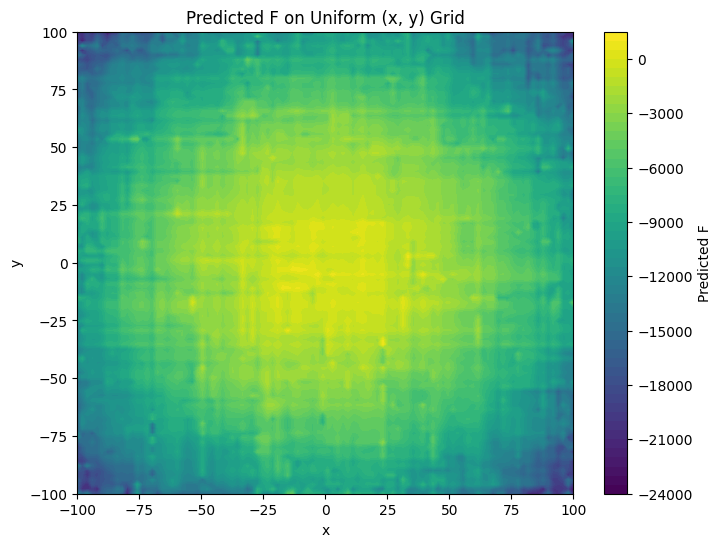

In [2]:
# データ読込（ヘッダー行をスキップ）
df = pd.read_csv("../data/sphere_sampled_benchmark_xy_F.csv", header=0)

# 特徴量と目的変数
X = df[["x", "y"]].values.astype(float)
y = df["F"].values.astype(float)

# モデル構築
reg = xgb.XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.1)
reg.fit(X, y)

# --- 均一なデータ生成 ---

# x, y の範囲決定
x_min, x_max = df["x"].min(), df["x"].max()
y_min, y_max = df["y"].min(), df["y"].max()

# 均一格子点を生成
n_grid = 100
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, n_grid),
    np.linspace(y_min, y_max, n_grid)
)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# 予測
F_pred = reg.predict(grid_points)
F_pred_grid = F_pred.reshape(xx.shape)

# 描画
plt.figure(figsize=(8,6))
contour = plt.contourf(xx, yy, F_pred_grid, 50, cmap="viridis")
plt.colorbar(contour, label='Predicted F')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted F on Uniform (x, y) Grid")
plt.show()

In [3]:
# grid_points と F_pred から df_uniform を作成
df_uniform = pd.DataFrame(grid_points, columns=['x', 'y'])
df_uniform['F_pred'] = F_pred
display(df_uniform.head(3))
display(df_uniform.tail(3))
display(df_uniform.shape)

df_uniform.to_csv("../data/sphere_pred_benchmark_xy_F.csv", index=False)
    

x      y        F_pred
0 -100.000000 -100.0 -12813.666992
1  -97.979798 -100.0 -15103.548828
2  -95.959596 -100.0 -13283.167969

x      y        F_pred
9997   95.959596  100.0 -16431.986328
9998   97.979798  100.0 -20221.658203
9999  100.000000  100.0 -18778.556641

(10000, 3)

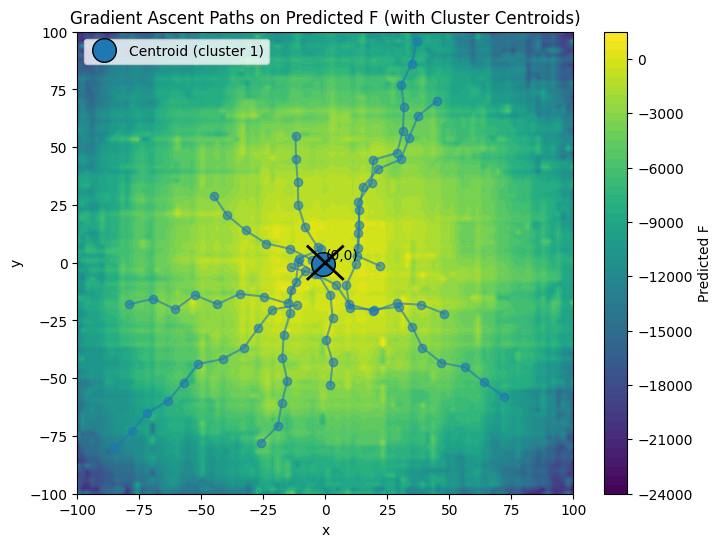

クラスタ重心の座標:
Cluster 1: x = -0.7184, y = -0.5227


In [410]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

def sample_circle_points(x0, y0, radius, n_samples):
    """中心(x0, y0), 半径radiusで均一ランダムにn_samples点サンプリング"""
    U = np.random.uniform(0, 1, n_samples)
    theta = np.random.uniform(0, 2*np.pi, n_samples)
    xs = x0 + radius * np.sqrt(U) * np.cos(theta)
    ys = y0 + radius * np.sqrt(U) * np.sin(theta)
    return np.c_[xs, ys]

def estimate_local_gradient(reg, x0, y0, sample_points):
    """局所回帰で勾配推定"""
    xs = sample_points[:, 0]
    ys = sample_points[:, 1]
    X_local = np.c_[xs - x0, ys - y0]
    y_local = reg.predict(sample_points)
    linreg = LinearRegression()
    linreg.fit(X_local, y_local)
    grad = linreg.coef_
    return grad

def one_gradient_ascent_path(reg, x0_init, y0_init, n_steps=8, radius=10, n_samples=100):
    x0, y0 = x0_init, y0_init
    path_x, path_y = [x0], [y0]
    prev_grad = None
    for step in range(n_steps):
        # サンプリング
        sample_points = sample_circle_points(x0, y0, radius, n_samples)
        grad = estimate_local_gradient(reg, x0, y0, sample_points)

        # 逆方向なら終了
        if prev_grad is not None:
            if np.dot(grad, prev_grad) < 0:
                break
        prev_grad = grad.copy()

        # 移動
        step_size = radius
        grad_norm = np.linalg.norm(grad)
        if grad_norm != 0:
            delta = grad / grad_norm * step_size
        else:
            delta = np.zeros_like(grad)
        x0 += delta[0]
        y0 += delta[1]
        path_x.append(x0)
        path_y.append(y0)
    return path_x, path_y

def calc_centroids_by_cluster(paths, labels, n_clusters):
    """各クラスタごとにパスの最終点の重心を計算"""
    final_points = np.array([[path_x[-1], path_y[-1]] for (path_x, path_y) in paths])
    centroids = []
    for k in range(n_clusters):
        cluster_points = final_points[labels == k]
        if len(cluster_points) > 0:
            centroid = cluster_points.mean(axis=0)
            centroids.append(centroid)
        else:
            centroids.append(np.array([np.nan, np.nan]))
    return np.array(centroids)

def select_optimal_k(X, k_min=2, k_max=8):
    """シルエットスコアによる最適クラスタ数選択"""
    best_k = k_min
    best_score = -1
    for k in range(k_min, min(len(X), k_max)+1):  # maxクラスタ数
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X)
        if len(set(labels)) == 1:  # クラスタ1個に全部まとめられた場合はcontinue
            continue
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_k = k
    return best_k

def plot_clustered_paths_and_centroids(xx, yy, F_pred_grid, paths, labels, centroids, plot_final_only=False):
    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, F_pred_grid, 50, cmap="viridis")
    n_clusters = len(np.unique(labels))
    # cluster毎の色
    colors = plt.cm.tab10.colors
    for idx, (path_x, path_y) in enumerate(paths):
        c = colors[labels[idx] % len(colors)]
        if plot_final_only:
            plt.plot(path_x[-1], path_y[-1], 'o', color=c, alpha=0.6)
        else:
            plt.plot(path_x, path_y, '-o', color=c, alpha=0.6)
    # 各クラスタの重心
    for i, centroid in enumerate(centroids):
        if np.any(np.isnan(centroid)):
            continue
        plt.plot(centroid[0], centroid[1], 'o', color=colors[i % len(colors)], 
                 markersize=17, markeredgecolor='black', label=f'Centroid (cluster {i+1})')
    # (0, 0)にばつ印を描画
    xlength = 7
    ylength = 7
    plt.plot([-xlength, xlength], [-ylength, ylength], color='black', lw=2, zorder=10)
    plt.plot([-xlength, xlength], [ylength, -ylength], color='black', lw=2, zorder=10)
    plt.text(0, 0, '(0,0)', color="black", fontsize=10, va='bottom', ha='left')
    plt.colorbar(label="Predicted F")
    plt.xlabel("x")
    plt.ylabel("y")
    if plot_final_only:
        plt.title("Final Points & Cluster Centroids of Gradient Ascent Paths on Predicted F")
    else:
        plt.title("Gradient Ascent Paths on Predicted F (with Cluster Centroids)")
    plt.legend(loc='best')
    plt.show()

def gradient_ascent_paths_clustering(
    reg, 
    xx, 
    yy, 
    F_pred_grid, 
    start_points,
    n_steps=8, 
    radius=10, 
    n_samples=100,
    plot_final_only=False,
    k_min=1,
    k_max=10
):
    """
    役割: 複数スタート点からgradient ascent pathを計算し、最終点でk-means++でクラスタリング、
    各クラスタごとに重心計算・描画
    """
    all_paths = []
    for (x0_init, y0_init) in start_points:
        path_x, path_y = one_gradient_ascent_path(
            reg, x0_init, y0_init, n_steps=n_steps, radius=radius, n_samples=n_samples
        )
        all_paths.append((path_x, path_y))
    # 最終点抽出
    final_points = np.array([[path_x[-1], path_y[-1]] for (path_x, path_y) in all_paths])
    # クラスタ数決定
    optimal_k = select_optimal_k(final_points, k_min=k_min, k_max=k_max)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(final_points)
    centroids = calc_centroids_by_cluster(all_paths, labels, optimal_k)
    plot_clustered_paths_and_centroids(xx, yy, F_pred_grid, all_paths, labels, centroids, plot_final_only)
    return all_paths, labels, centroids

# 例えば複数点から開始
start_points = [(np.random.randint(-100, 100), np.random.randint(-100, 100)) for _ in range(10)]
paths, labels, centroids = gradient_ascent_paths_clustering(
    reg=reg, 
    xx=xx, 
    yy=yy, 
    F_pred_grid=F_pred_grid, 
    start_points=start_points,
    n_steps=10, 
    radius=10, 
    n_samples=100,
    plot_final_only=False,
    k_min=1,
    k_max=1
)

# --- 追加: 最終的なクラスタの重心の座標を出力 ---
print("クラスタ重心の座標:")
for i, centroid in enumerate(centroids):
    if np.any(np.isnan(centroid)):
        continue
    print(f"Cluster {i+1}: x = {centroid[0]:.4f}, y = {centroid[1]:.4f}")
